In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Looking at the Narscisism data

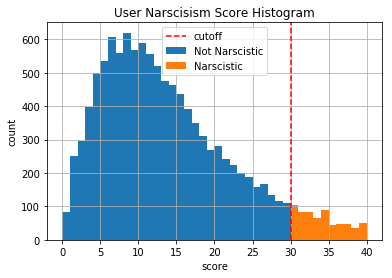

In [16]:
# Read in the dataset
df = pd.read_csv('data.csv')

#plot the scores
idx = df.score < 30
ax = df.score[idx].hist(bins = range(0,31),label = 'Not Narscistic')
idx = df.score >= 30
ax.hist(df.score[idx],label = 'Narscistic')
ax.set_xlabel('score')
ax.set_ylabel('count')
ax.set_title('User Narscisism Score Histogram')
ax.axvline(30,0,600,c = 'r',ls = '--',label ='cutoff')
ax.legend();

From above, we can identify users as narscistic if they answer enough questons that push their score above 30.

My goal is to find the questions that are answered the most differently between users that are narscistic vs not narscistic.  

Initially, I am going to get rid of some of the data in this set that is bad.  There are 2 defining factors that I identified as making the data bad.
1. Remove all test takers that said their age was **greater** than 100 or **less than** 15
2. Remove all test takers who took longer than 10,000 seconds to take the test

#### Histogram of user age -- Before and After a log transformation

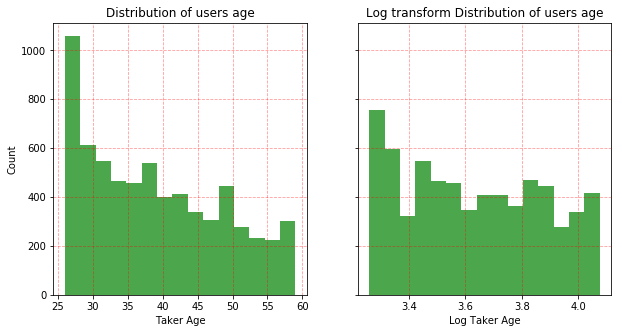

In [17]:
# Find the Index of the nonoutliers
df_idx = (df['age'] < 60) & (df['age'] > 25)
# Only save the good data
df = df.loc[df_idx,:]
#Create a subplots object
_,ax = plt.subplots(1,2,figsize = (10,5),sharey = True)
#plot the two histograms
ax[0].hist(df['age'], bins = 15,alpha = .7,color = 'g');
ax[1].hist(np.log(df['age']), bins = 15,alpha = .7,color = 'g');
#Set X and Y labels
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Taker Age')
ax[1].set_xlabel('Log Taker Age')
# Set the titles
ax[0].set_title('Distribution of users age')
ax[1].set_title('Log transform Distribution of users age')
#add the grid
ax[1].grid(alpha = .4, c = 'r',ls = '--')
ax[0].grid(alpha = .4, c = 'r',ls = '--')

### Test time elapsed removal:

Now lets take a look at the Distribution of the elapsed time.  Lets exclude users who took more than 10,000 seconds.  As well, going to take the log of these numbers so that the distribution looks a litle better

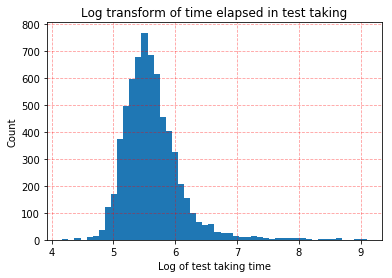

In [18]:
# Find the index of the non outliers in time to take the test
df_idx = df['elapse'] < 10000

# Get rid of the outliers
df = df.loc[df_idx,:]

# plot the histogram
plt.hist(np.log(df['elapse']), bins = 50);

# set the xlabel, ylabel and the title
plt.xlabel('Log of test taking time')
plt.ylabel('Count')
plt.title('Log transform of time elapsed in test taking')

# add a grid
plt.grid(alpha = .4, c = 'r',ls = '--')

### Data is cleaned, Ready for analysis
Now that we have the data cleaned, we are ready to start looking at what identifies people as narcissitic the most.

The way these questions are organized is that there are _40_ questions, and within these questions the test taker is required to choose a statement that they identify most with.  Then at the end of the test, the test sums the number of questions that are identified with narcissistic personality.  I will reoder the questions into a dictionary where the first value **always** is identified with being more narcissistic.

Below is the code to do this

In [19]:
# Questions identified as being narcissitic with answer A
Questions_A = [1, 2, 3, 6, 8, 11, 12, 13, 14, 16,
               21, 24, 25, 27, 29, 30, 31, 33, 34,
              36, 37, 38, 39]
# Questions identified as being narcissitic with answer B
Questions_B = [4, 5, 7, 9, 10, 15, 17, 18, 19, 20,
               22, 23, 26, 28, 32, 35, 40]
#create the dictionary, and go through the text file containing the questions and answers
questions = {}
with open('codebook.txt') as f:
    for i in range(4):
        f.readline()
    for i,line in enumerate(f):
        if i == 40:
            break
        data = line.split('.')
        if i + 1 in Questions_A:
            questions[data[0]] = [data[1].replace("1=",'').strip(),
                                              data[2].replace("2=",'').strip()]
        else:
            questions[data[0]] = [data[2].replace("2=",'').strip(),
                                              data[1].replace("1=",'').strip()]

### Questions that imply narcissism:
Now that I have taken these questions and organized them accordingly, We can take a look at the questions that are identified with people being narcissitic:

In [20]:
# Build the table (requires a couple imports)
import textwrap
from prettytable import PrettyTable

# Set up the table that we will be adding each to
t = PrettyTable(["Q's that impply Narcissism", "Q's that imply not Narcissism"])

# Go through each question and add each to the table
for i, quest in enumerate(questions.values()):
    
    # Wrap the text questions so that we have nice formatting
    q1 = textwrap.fill(quest[0], 30)
    q2 = textwrap.fill(quest[1], 30)
    
    # add the question to the table
    t.add_row([q1,q2])
    t.add_row(['--','--'])
print(t)

+--------------------------------+--------------------------------+
|   Q's that impply Narcissism   | Q's that imply not Narcissism  |
+--------------------------------+--------------------------------+
|  I have a natural talent for   |  I am not good at influencing  |
|       influencing people       |             people             |
|               --               |               --               |
|   Modesty doesn't become me    |   I am essentially a modest    |
|                                |             person             |
|               --               |               --               |
| I would do almost anything on  | I tend to be a fairly cautious |
|             a dare             |             person             |
|               --               |               --               |
| I know that I am good because  |  When people compliment me I   |
| everybody keeps telling me so  |   sometimes get embarrassed    |
|               --               |              

### Scaling the answers to make the analysis simplier:

I am going to apply a scaling function to the answers so that the analysis works a little better and is slightly cleaner

In [21]:
# Import the scaling Function
from sklearn.preprocessing import StandardScaler as SS

#Initialize the scaler
scaler = SS()

#apply the scaling to the whole dataset
sc_df = pd.DataFrame(scaler.fit_transform(df),columns = df.columns)

Now that we have have removed the outliers, and scaled the answers, lets go ahead and start doing some real analysis.

PCA will identify the components of the data - set where there is the most variation in answers.  Using this information, I will then identify the questions that seperate users the most.  Since PCA gives some of the components as negative values, I will later on explore **NMF** but for now this is a good start

In [22]:
# Take only the columns from our dataset that correspond to question Answers
nar_df = sc_df.loc[:,'Q1':'Q40']

# Import the PCA module
from sklearn.decomposition import PCA

#create the PCA object and apply it to the dataset
model = PCA(n_components=5)
model.fit(nar_df);

Lets take a look at how much variation in the Dataset is explained by the first couple priciple components that where Identified:

In [23]:
def scree_plot(pca, title=None):
    num_components = pca.n_components_
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    plt.figure(figsize=(10, 6), dpi=250)
    ax = plt.subplot(111)
    ax.bar(ind, vals, 0.35,
           color=[(0.949, 0.718, 0.004),
                  (0.898, 0.49, 0.016),
                  (0.863, 0, 0.188),
                  (0.694, 0, 0.345),
                  (0.486, 0.216, 0.541),
                  (0.204, 0.396, 0.667),
                  (0.035, 0.635, 0.459),
                  (0.486, 0.722, 0.329),
                 ])

    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)

    ax.set_xticklabels(ind,
                       fontsize=12)

    ax.set_ylim(0, max(vals)+0.05)
    ax.set_xlim(0-0.45, 8+0.45)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)

    ax.set_xlabel("Principal Component", fontsize=12)
    ax.set_ylabel("Variance Explained (%)", fontsize=12)

    if title is not None:
        plt.title(title, fontsize=16)

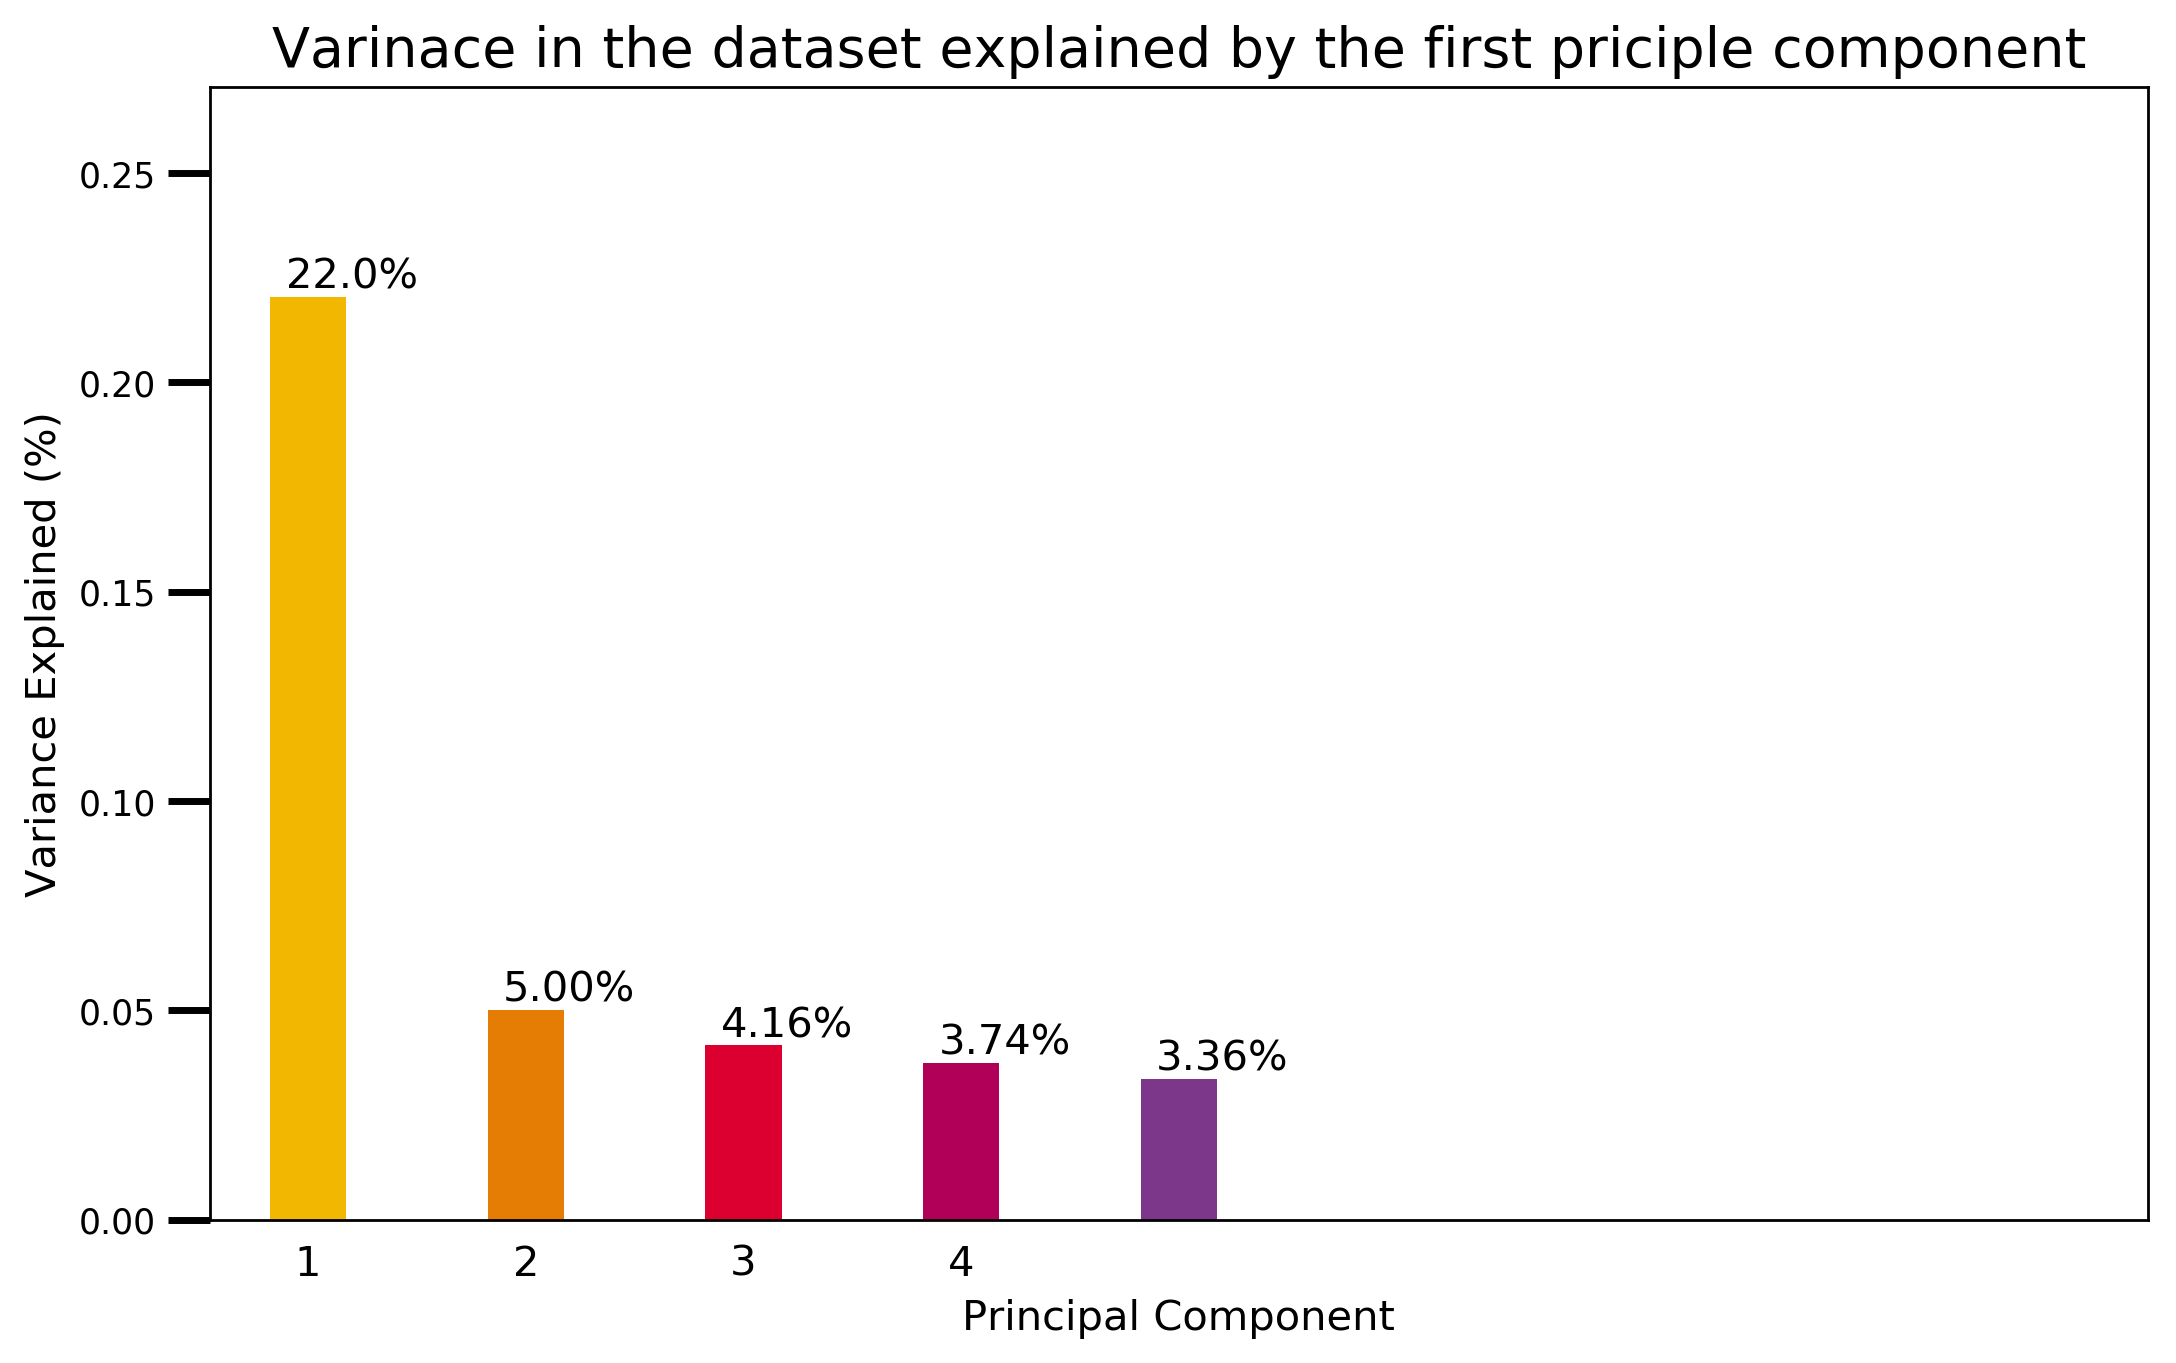

In [24]:
scree_plot(model,title = 'Varinace in the dataset explained by the first priciple component')

### PCA explained variance
We can see from the above plot that over 20% of the variance in the dataset is explained by the first principle component. Using this information, we can also look at the questions that are giving this component the most signal.  

- Later on I will aggragate the first 5 components, and see what questions are most important in all 5.  For now, I will be just looking at the first component

Below is a list of the most influencial questions in terms of explaining variance in the first PCA Component

In [25]:
np.argsort(np.abs(model.components_[0]))

array([21, 16, 10, 36, 23, 13,  2,  0, 18, 25, 14, 27, 28, 15, 20,  9,  7,
       17, 37,  4,  1, 33, 30, 38, 19, 22,  6, 32,  8, 11,  3,  5, 24, 12,
       31, 29, 34, 39, 35, 26])

### What where users answers from these questions?

- Lets see how users responded to these questions and what kind of split they give

In [32]:
# Define the people who are narcissistic
nar_idx = df.score > 30
nar_idx = nar_idx.reset_index()
nar_idx = nar_idx['score']

# Define the people who are not narcissistic
not_idx = df.score < 30
not_idx = not_idx.reset_index()
not_idx = not_idx['score']
def plot_top_n(components,scaled_df,nar_idx, not_idx,num_comp):

    # Go through the top 'n questions
    for i in range(num_comp):
        # Create the plot
        _,ax = plt.subplots(1,2,figsize = (10,5),sharey = True)
        
        # define the question we are looking at
        name = 'Q'+str(components[i]+ 1)
        data = scaled_df[name].reset_index()
        
        # Get the tick values (since we scaled them they are a little strange)
        tick_vals = sorted(list(set(scaled_df[name])))
        
        # create the bins for plotting
        b = []
        for val in tick_vals:
            b.append(val-.5)
            b.append(val+.5)
            
        # plot the histograms
        data[nar_idx][name].hist(density = 1,alpha = .5,
                                 ax = ax[0],bins = b)
        data[not_idx][name].hist(density = 1,alpha = .5,
                                 ax = ax[1],bins = b,
                                 color = 'r')

        # Set the tick marks
        ax[0].set_xticks(tick_vals)
        ax[1].set_xticks(tick_vals)
        
        #Code to get the right labels
        if components[i]+ 1 in Questions_A:
            nar = 0
            not_nar = 1
        else:
            nar = 1
            not_nar = 0
        ax[1].set_xticklabels(['No Answer',
                               questions[name][nar],
                               questions[name][not_nar]],
                              rotation=75)
        ax[0].set_xticklabels(['No Answer',
                               questions[name][nar],
                               questions[name][not_nar]],
                              rotation=75)
        # Add a grid
        ax[0].grid(alpha = .4, c= 'g',ls = '--')
        ax[1].grid(alpha = .4, c= 'g',ls = '--')
        
        #add a title
        ax[0].set_title(name + 'People who are Narcissistic answers')
        ax[1].set_title(name + 'People who are NOT Narcissistic answers')
        plt.show()

[21 16 10 36 23 13  2  0 18 25 14 27 28 15 20  9  7 17 37  4  1 33 30 38
 19 22  6 32  8 11  3  5 24 12 31 29 34 39 35 26]


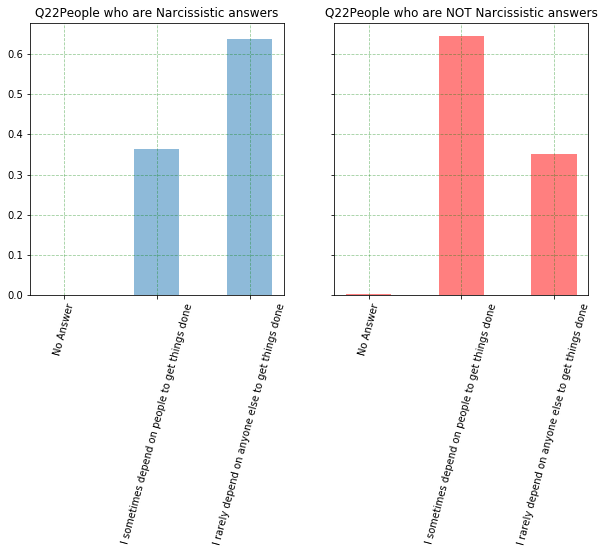

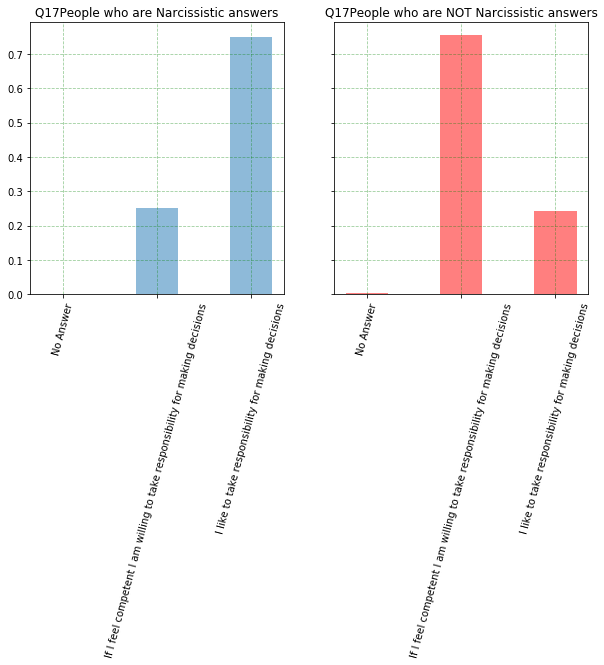

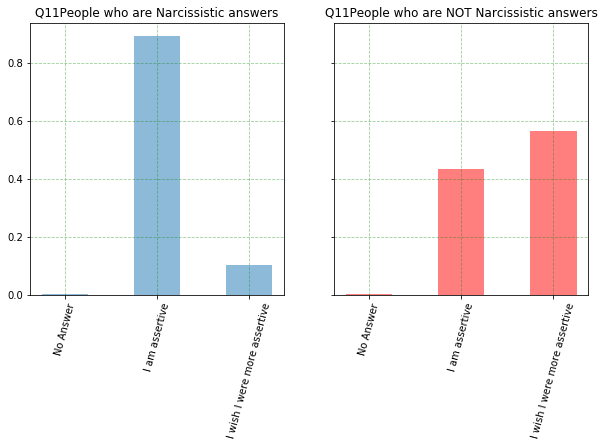

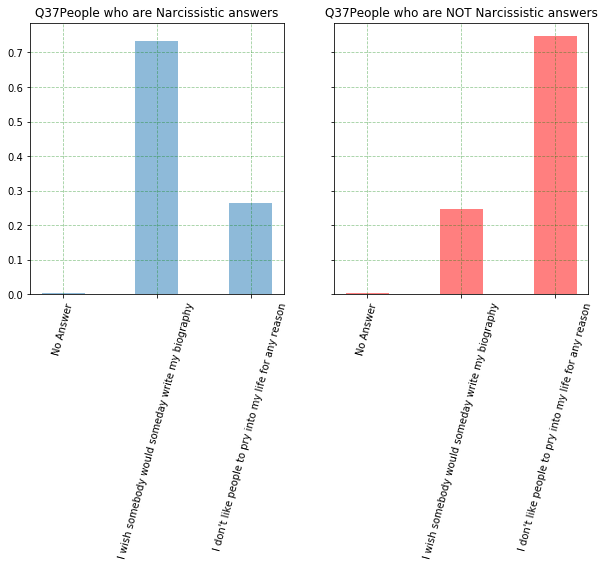

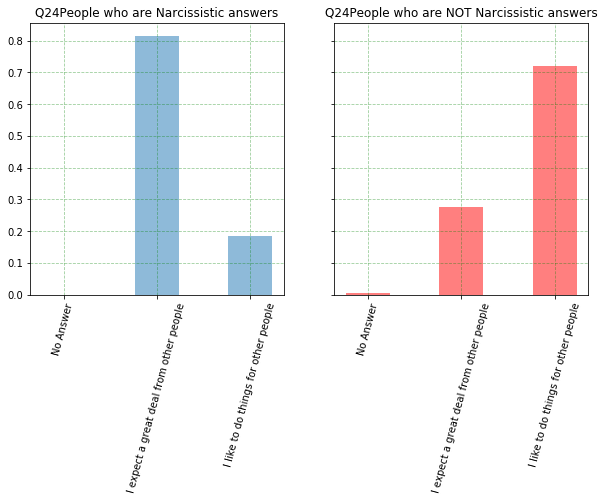

In [33]:
components = np.argsort(np.abs(model.components_[0]))
print(components)
plot_top_n(components,sc_df,nar_idx, not_idx,5)

Finally, I can look at the questions that are identified the most throughout all of the principle components

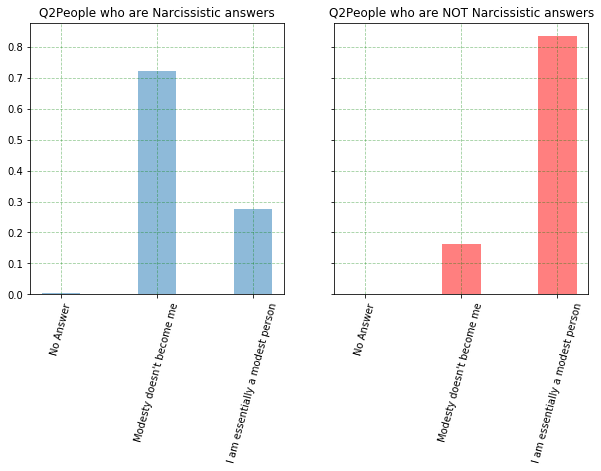

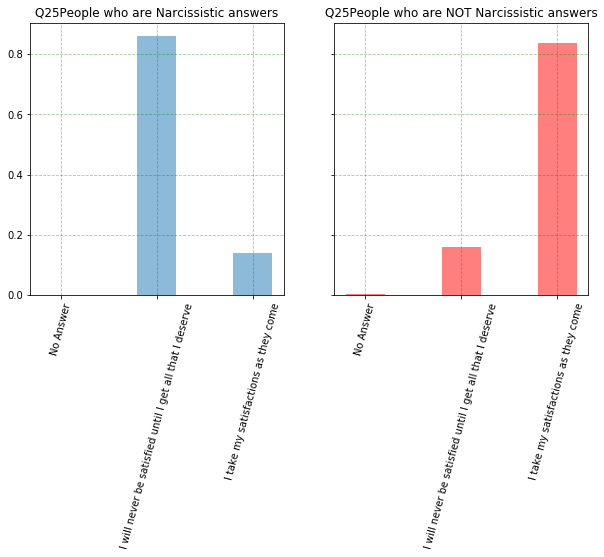

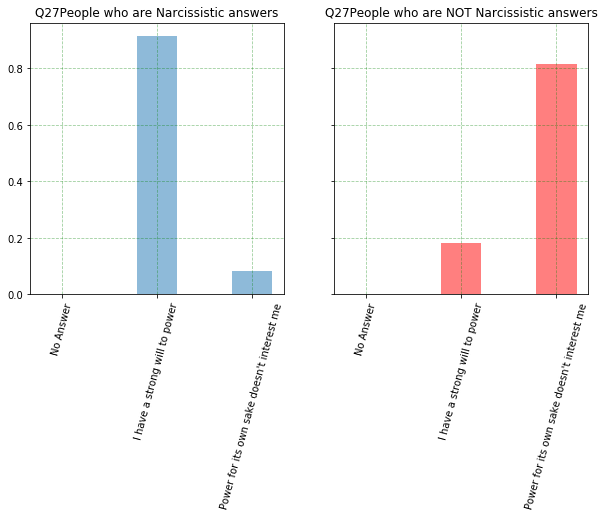

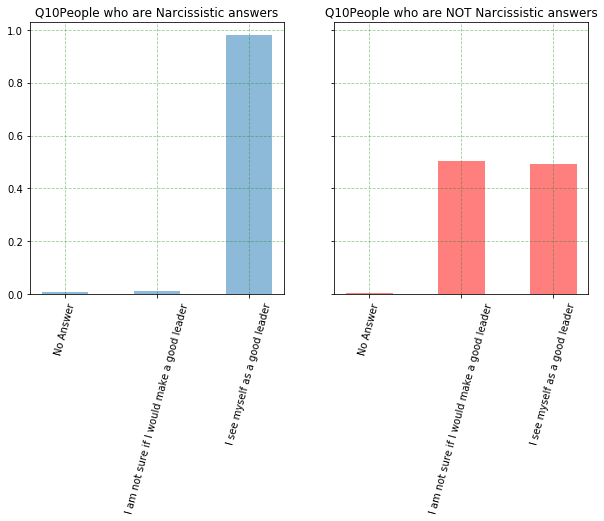

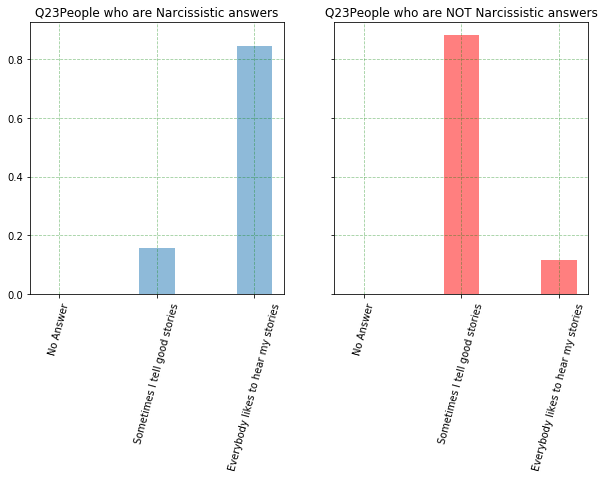

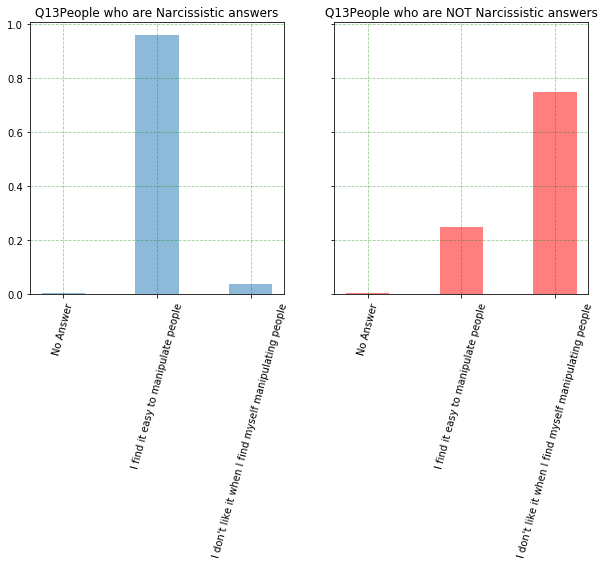

KeyError: 'Q0'

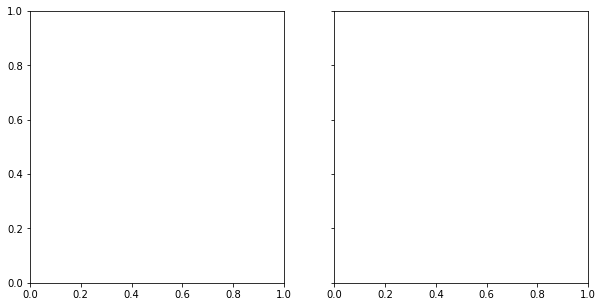

In [28]:
components = []
for i in range(5):
    components.append(np.argsort(np.abs(model.components_[i]))[0:10])
from collections import Counter
important_qs = Counter(np.array(components).flatten()).most_common(10)
components = [x[0] for x in important_qs]  
plot_top_n(components,sc_df,nar_idx, not_idx,9)

### Lets Run NMF on this same data

In [29]:
from sklearn.decomposition import NMF
nmf_df = df.loc[:,'Q1':'Q40']

In [34]:
model = NMF(n_components=5, max_iter= 1000)
model.fit_transform(nmf_df);

In [35]:
model.n_iter_

999

10
110
210
310
410
510
610
710
810
910
1010
1110
1210
1310
1410
1510
1610
1710
1810
1910
2010
2110
2210
2310
2410
2510
2610
2710
2810
2910
3010
3110
3210
3310
3410
3510
3610
3710
3810
3910
4010
4110
4210
4310
4410
4510
4610
4710
4810
4910
5010
5110
5210
5310
5410
5510
5610
5710
5810
5910
6010
6110
6210
6310
6410
6510
6610
6710
6810
6910
7010
7110
7210
7310
7410
7510
7610
7710
7810
7910
8010
8110
8210
8310
8410
8510
8610
8710
8810
8910
9010
9110
9210
9310
9410
9510
9610
9710
9810
9910


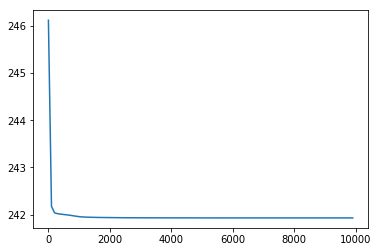

In [45]:
lst = []
for i in range(10,10000,100):
    model = NMF(n_components=5, max_iter= i)
    model.fit_transform(nmf_df);
    lst.append(model.reconstruction_err_)
    print(i)
plt.plot(range(10,10000,100),lst)

In [44]:
model.reconstruction_err_

241.9558875766462